# Promoter distance analysis
As in Figure 4 of the paper, we can explore the relationship of expression patterns with distance from the transcriptional start site. Data on promoter annotations are included and available at https://aureowiki.med.uni-greifswald.de/. Note that in comparison to *E. coli*, the relationships for *S. aureus* are very weak.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import seaborn as sns
import scvi

# Set plotting parameters
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### 1. Calculate gene-level statistics
Import data (we use the original data from the paper rather than the outputs from the other notebooks):

In [2]:
from math import pi

gene_information = pd.read_table('samples/tsb_gene_information.txt', index_col=0)
predicted_angle = pd.read_table('samples/tsb_predicted_angle.txt',
                                      index_col=0)['angle_pred']
predicted_angle_degrees = (180 / pi) * (predicted_angle + pi)
gene_information['predicted_angle'] = np.array(predicted_angle_degrees)

gene_information

,gene_angle,correction_std,highly_variable,cycle_variable,predicted_angle
SAUSA300_RS00010,67.093540,0.875103,True,True,341.470210
SAUSA300_RS00015,67.072090,0.889347,True,True,342.045001
SAUSA300_RS00020,357.643520,0.342809,False,False,342.575956
SAUSA300_RS00025,348.444670,0.208566,False,False,342.660825
SAUSA300_RS00030,335.045170,0.338761,True,False,343.054306
...,...,...,...,...,...
SAUSA300_RS14680,59.707703,0.658022,True,True,342.773398
SAUSA300_RS14685,40.406296,0.557517,True,True,342.115141
SAUSA300_RS14690,37.988495,0.459668,False,False,341.608033
SAUSA300_RS14695,45.599243,0.422238,False,False,341.435491


Calculate the angle difference and visualize:

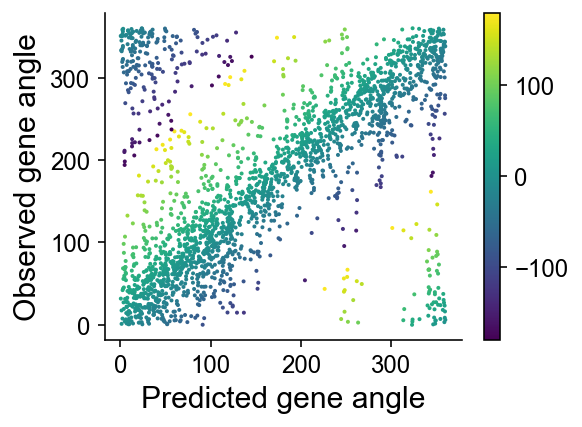

In [3]:
def angle_difference(data):
    x = data['gene_angle'] * pi / 180
    y = data['predicted_angle'] * pi / 180
    
    return 180 * np.arctan2(np.sin(x-y), np.cos(x-y)) / pi

gene_information['angle_difference'] = gene_information.apply(angle_difference, axis=1)

plt.figure(figsize=(4,3))
plt.scatter(gene_information['predicted_angle'], gene_information['gene_angle'], s=1,
            c=gene_information['angle_difference']
           )
plt.xlabel('Predicted gene angle', size=15)
plt.ylabel('Observed gene angle', size=15)
plt.colorbar()

Here, a positive "angle difference" indicates that observed expression patterns occur "later" than expected based on chromosome position, a negative one indicates that observed expression patterns occur "earlier" than expected.

Unlike *E. coli*, as described in Figure 4 of the paper, there is no excess of divergent genes with a positive angle difference in *S. aureus*:

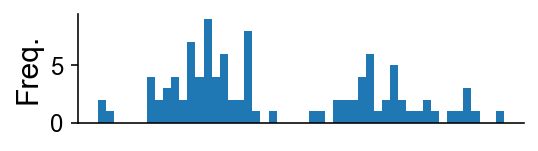

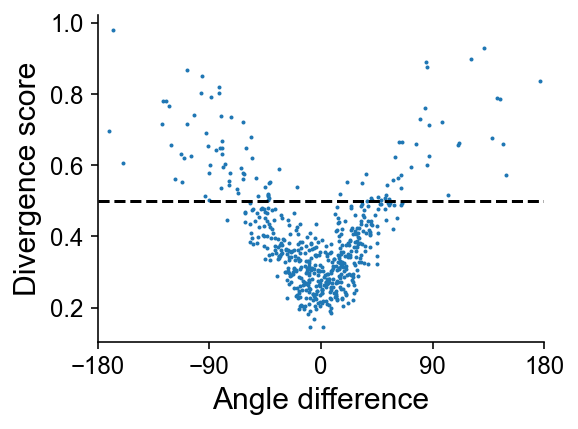

In [4]:
plt.figure(figsize=(4,1))

plt.hist(gene_information.loc[
    (gene_information['highly_variable']) & (gene_information['correction_std'] > 0.5), 
    'angle_difference'], bins=50)
plt.xticks([])
plt.ylabel('Freq.', size=15)
plt.show()

plt.figure(figsize=(4,3))

plt.scatter(
    gene_information.loc[gene_information['highly_variable'], 'angle_difference'],
    gene_information.loc[gene_information['highly_variable'], 'correction_std'],
    s=1
)
plt.hlines(xmin=-180, xmax=180, y=0.5, linestyles='dashed', color='black')

plt.xlim(-180, 180)
plt.xticks([-180, -90, 0, 90, 180])
plt.xlabel('Angle difference', size=15)
plt.ylabel('Divergence score', size=15)
plt.show()

In [5]:
print('Number of "delayed" genes:')
print(np.sum((gene_information['highly_variable']) &
             (gene_information['correction_std'] > 0.5) &
             (gene_information['angle_difference'] > 0)
     ))

print('Number of "early" genes:')
print(np.sum((gene_information['highly_variable']) &
             (gene_information['correction_std'] > 0.5) &
             (gene_information['angle_difference'] < 0)
     ))

Number of "delayed" genes:
40
Number of "early" genes:
62


We also want to calculate the amplitude. To do this, we get the scVI-smoothed expression, binned by cell angle, and then simply measure the peak-to-trough fold change. Because this could be sensitive to individual outliers, we introduce an "offset" so that we measure the (n + 1)th lowest and the nth highest values (here n = 3).

Import the data and generate angle-binned expression:

In [6]:
# Get normalized expression
adata = sc.read_h5ad('outputs/tsb_adata.h5ad')
model = scvi.model.SCVI.load('samples/D5_scVI_model', adata)
cell_angles = pd.read_table('samples/tsb_cell_angles.txt', index_col=0)['cell_angle']
adata = adata[cell_angles.index,:]
scvi.settings.seed = 123
normalized_expression = model.get_normalized_expression(adata)

# Get angle-binned expression
binned_angles = np.zeros(len(cell_angles))

angle_bins = np.linspace(0, 360, 101)

for i in range(len(angle_bins) - 1):
    binned_angles[(cell_angles >= angle_bins[i]) & (cell_angles < angle_bins[i+1])] = i
    
angle_binned_normalized_expression = normalized_expression.\
    assign(angle_bin = binned_angles).groupby('angle_bin').mean()

INFO     .obs[_scvi_batch] not found in target, assuming every cell is same category         
INFO     .obs[_scvi_labels] not found in target, assuming every cell is same category        
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 49307 cells, 2345 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Received view of anndata, making copy.                                              


Now calculate the fold change:

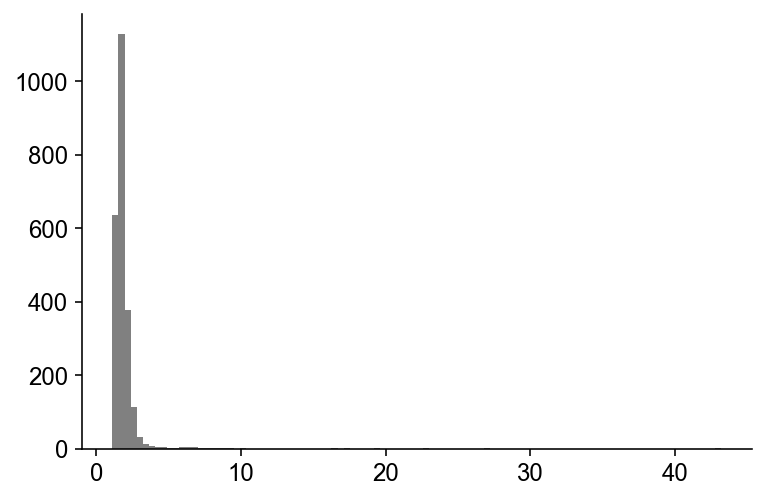

In [7]:
def get_fc(x, offset=3):
    x_sorted = np.array(x)[np.argsort(x)]
    x_low = x_sorted[offset]
    x_high = x_sorted[-offset]
    return x_high / x_low

all_fc = angle_binned_normalized_expression.apply(get_fc, axis=0)
gene_information['fold_change'] = all_fc[gene_information.index]

# Take a look at the distribution of fold-changes
plt.hist(gene_information['fold_change'], bins=100, color='grey')
plt.show()

### 2. Import and extract TSS distance annotations
Now we get the gene distances, downloaded from https://biocyc.org/. We use these to build gene distances from the transcription start site, taking the maximum TSS distance where a gene belongs to multiple transcription units.

In [8]:
# Load in file
gff = pd.read_csv("reference/GCF_000013465.1_ASM1346v1_genomic.gff.gz",
                  sep="\t", comment='#', names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])

# Save chromosome length
chrom_length = gff.loc[0, 'end']

# Format and parse columns
gff = gff[gff['feature'] == 'gene']
gff['name'] = gff['attribute'].str.replace("^.*;Name=", "", regex=True).str.replace(";.*$", "", regex=True)
gff['locus_tag'] = gff['attribute'].str.replace("^.*;locus_tag=", "", regex=True).str.replace(";.*$", "", regex=True)
gff = gff[['chrom', 'start', 'end', 'strand', 'name', 'locus_tag']]
gff.reset_index(inplace=True)

# Set the gene coordinate as the start codon position
def set_coord(x):
    if x['strand'] == '+':
        return x['start']
    elif x['strand'] == '-':
        return x['end']
    else:
        raise ValueError('Strand should not be ' + x['strand'])

gff['coord'] = gff.apply(set_coord, axis=1)

# Sort and filter
gff.index = gff['locus_tag']
gff = gff.loc[pd.Series(adata.var_names),:]
gff = gff.sort_values('coord')

# Filter out extrachromosomal genes:
gff = gff.loc[gff['chrom'] == 'NC_007793.1']

gff.head()

,index,chrom,start,end,strand,name,locus_tag,coord
locus_tag,,,,,,,,
SAUSA300_RS00010,1,NC_007793.1,544,1905,+,dnaA,SAUSA300_RS00010,544
SAUSA300_RS00015,3,NC_007793.1,2183,3316,+,dnaN,SAUSA300_RS00015,2183
SAUSA300_RS00020,5,NC_007793.1,3697,3942,+,yaaA,SAUSA300_RS00020,3697
SAUSA300_RS00025,7,NC_007793.1,3939,5051,+,recF,SAUSA300_RS00025,3939
SAUSA300_RS00030,9,NC_007793.1,5061,6995,+,gyrB,SAUSA300_RS00030,5061


Import TU information (data downloaded from https://aureowiki.med.uni-greifswald.de). Note that since Aureowiki uses the old locus tags (SAUSA300_####), we import a file to allow conversion to the new locus tags (SAUSA300_RS#####):

In [9]:
gene_info = pd.read_table("reference/USA300_FPR3757_info.txt",
                         index_col=5)
aureowiki_operons = pd.read_table('reference/aureowiki_operons.tsv', sep="\t")
aureowiki_operons = aureowiki_operons.loc[aureowiki_operons['locus tag'].isin(gene_info['old_locus_tag'])]
old_new = pd.Series(gene_info.index, index=gene_info['old_locus_tag'])
aureowiki_operons.index = old_new[aureowiki_operons['locus tag']]
aureowiki_operons

,locus tag,BioCyc,operon
locus_tag,,,
SAUSA300_RS00010,SAUSA300_0001,GH3C-1,no polycistronic organisation predicted
SAUSA300_RS00015,SAUSA300_0002,GH3C-2,no polycistronic organisation predicted
SAUSA300_RS00020,SAUSA300_0003,GH3C-3,SAUSA300_0003 > SAUSA300_0004 > SAUSA300_0005 ...
SAUSA300_RS00025,SAUSA300_0004,GH3C-4,SAUSA300_0003 > SAUSA300_0004 > SAUSA300_0005 ...
SAUSA300_RS00030,SAUSA300_0005,GH3C-5,SAUSA300_0003 > SAUSA300_0004 > SAUSA300_0005 ...
...,...,...,...
SAUSA300_RS14895,SAUSA300_pUSA030031,GH3C-2665,no polycistronic organisation predicted
SAUSA300_RS14905,SAUSA300_pUSA030033,GH3C-2667,no polycistronic organisation predicted
SAUSA300_RS14915,SAUSA300_pUSA030034,GH3C-2668,SAUSA300_pUSA030034 > SAUSA300_pUSA030035 (Mic...


Remove genes without operon annotations:

In [10]:
aureowiki_operons = aureowiki_operons.loc[~aureowiki_operons['operon'].isna()]

Create the operon annotations:

In [11]:
operons_set = set()

for i in range(aureowiki_operons.shape[0]):
    gene = aureowiki_operons.index[i]
    operon = aureowiki_operons['operon'][i]
    if operon == 'no polycistronic organisation predicted':
        genes = (gene,)
    else:
        operon = operon.rstrip(' (MicrobesOnline)')
        if '>' in operon:
            genes = tuple([old_new[g] for g in operon.split(' > ') if g in old_new.index])
        if '<' in operon:
            genes = tuple([old_new[g] for g in reversed(operon.split(' < ')) if g in old_new.index])
    operons_set.add(tuple([g for g in genes if g in gff.index and g in gene_information.index]))
            
operons_dict = {'-'.join(genes): genes for genes in operons_set}

Now construct gene-level information for each transcription unit. We exclude transcription units that have only one gene in as the TSS distance signal for these is likely to be very weak and only contribute noise.

In [12]:
from collections import OrderedDict

def get_gene_positions(operon):
    genes = [g for g in operons_dict[operon]]
    if len(genes) == 0:
        return None

    gene_strands = gff.loc[genes, 'strand']
        
    if all(strand == '+' for strand in gene_strands):
        operon_start = gff.loc[genes[0], 'start']
        operon_end = gff.loc[genes[-1], 'end']
        
    elif all(strand == '-' for strand in gene_strands):
        operon_start = gff.loc[genes[0], 'end']
        operon_end = gff.loc[genes[-1], 'start']
        
    else:
        raise ValueError('strands should all either be + or -')
    
    midpoints = gff.loc[genes, ['start', 'end']].mean(axis=1)
    correction_std = gene_information.loc[genes, 'correction_std']
    angle_difference = gene_information.loc[genes, 'angle_difference']
    
    gene_df = pd.DataFrame(
        {
            'midpoint': midpoints,
            'correction_std': correction_std,
            'angle_difference': angle_difference,
        }
    )
    
    gene_df['distance'] = np.abs(gene_df['midpoint'] - operon_start)
    
    gene_df.sort_values('distance', inplace=True)
        
    output_dict = {
        'start': operon_start,
        'end': operon_end,
        'length': np.abs(operon_end - operon_start) + 1,
        'n_genes': len(genes),
        'gene_data': gene_df
    }
    
    return output_dict
    
tu_profiles = OrderedDict()

for TU in operons_dict.keys():
    tu_profile = get_gene_positions(TU)
    if tu_profile != None and tu_profile['n_genes'] > 1: # Polycistrons only
        tu_profiles[TU] = tu_profile

Now scan through this to get maximum TSSs for each gene (those without an annotated TSS have a distance set to zero).

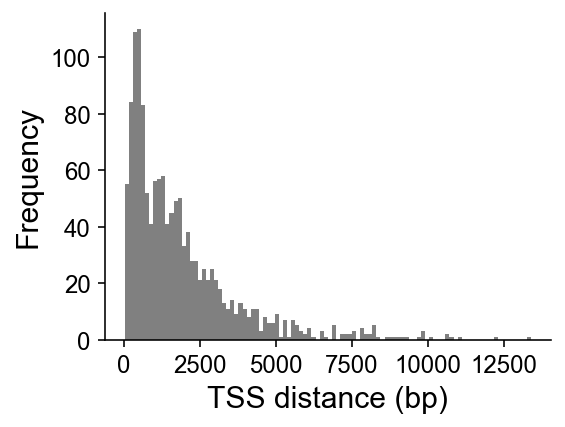

In [13]:
# Initialize a series of zeros
gene_distance = pd.Series([0.0] * gene_information.shape[0], index=gene_information.index)

# Loop through all the transcription units
for tu in tu_profiles.values():
    gene_data = tu['gene_data']
    
    # Loop through the genes within a TU
    for gene, distance in zip(gene_data.index, gene_data['distance']):
        
        # If the distance of a gene from its TSS within this operon is greater than the currently
        # registered one, include the new TSS distance.
        # (all distances start off at zero so they will be replaced by any annotated TU distances)
        if gene_distance[gene] < distance:
            gene_distance[gene] = distance
            
# Visualize, leaving out the zeros (denoting where no annotated TSS)
plt.figure(figsize=(4,3))
plt.hist(gene_distance[gene_distance != 0], bins=100, color='grey')
plt.xlabel('TSS distance (bp)', size=15)
plt.ylabel('Frequency', size=15)
plt.show()

Now finally, construct the plot for the relationship between angle difference and distance from the TSS:

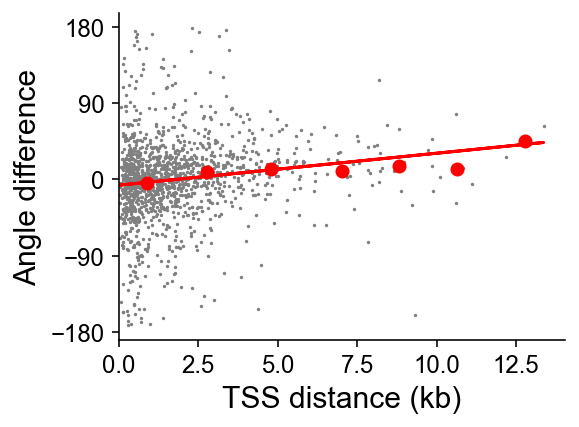

Spearman correlation for this relationship:
SpearmanrResult(correlation=0.18114840606449412, pvalue=1.667595155623718e-11)


In [14]:
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

# Include gene distances and filter so that only nonzero distances (i.e. those with an annotated TSS) are included
gene_information['distance'] = gene_distance
gene_information_filt = gene_information.loc[gene_information['distance'] > 0]

# Fit a linear model relating angle difference to TSS distance
distance_x = np.array(gene_information_filt['distance'])[:,np.newaxis]
distance_delay_model = LinearRegression().fit(distance_x, np.array(gene_information_filt['angle_difference']))

plt.figure(figsize=(4,3))

# Plot angle difference against maximum TSS distance for individual genes
plt.scatter(gene_information_filt['distance'] / 1e3,
            gene_information_filt['angle_difference'],
           s=0.5, color='grey')

# Average angle difference by 2 kb bins of TSS distance
# The purpose of this is to look at local averages, thus demonstrating that the trend holds across
# the distribution and not just for unusually long operons.
distance_bins = gene_information_filt.assign(distance_bin = pd.cut(gene_information['distance'],
                                                              list(range(0, 19000,2000)))).\
    groupby('distance_bin').mean()

plt.scatter(distance_bins['distance'] / 1e3, distance_bins['angle_difference'],
           color='red')

# Plot the fitted regression
plt.plot(gene_information_filt['distance'] / 1e3,
         distance_delay_model.predict(distance_x), color='red')

plt.xlim(xmin=0)
plt.yticks((-180, -90, 0, 90, 180))
plt.xlabel('TSS distance (kb)', size=15)
plt.ylabel('Angle difference', size=15)
plt.show()

print('Spearman correlation for this relationship:')
print(spearmanr(gene_information_filt['distance'],
            gene_information_filt['angle_difference']))

We use this regression fit to estimate RNAP speed. To do this, we assume that a 360° rotation by gene angle is equivalent to one doubling time. Then we use the inverse of the regression fit as follows:

In [15]:
td = 25 # doubling time
1 / (td * 60 * distance_delay_model.coef_ / 360)

array([63.65216209])

We can also do an equivalent analysis on log-fold change to demonstrate a relationship between distance from the TSS and cell cycle amplitude:

<ipython-input-16-2d9295f563dc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_information_filt['LFC'] = np.log2(all_fc[gene_information_filt.index])


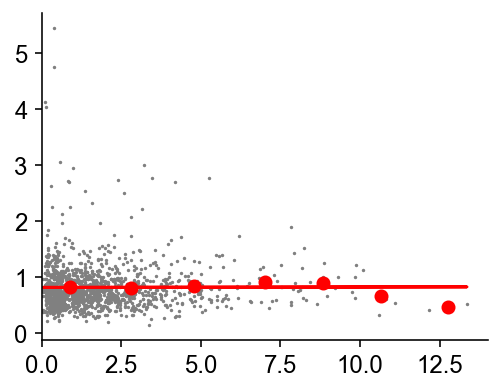

Spearman correlation for this relationship:
SpearmanrResult(correlation=0.009441573880089258, pvalue=0.7278373746533058)


In [16]:
gene_information_filt['LFC'] = np.log2(all_fc[gene_information_filt.index])

distance_x = np.array(gene_information_filt['distance'])[:,np.newaxis]
distance_fc_model = LinearRegression().fit(distance_x, np.array(gene_information_filt['LFC']))

plt.figure(figsize=(4,3))

plt.scatter(gene_information_filt['distance'] / 1e3,
            gene_information_filt['LFC'],
           s=0.5, color='grey')

distance_bins = gene_information_filt.assign(distance_bin = pd.cut(gene_information['distance'],
                                                              list(range(0, 19000,2000)))).\
    groupby('distance_bin').mean()

plt.scatter(distance_bins['distance'] / 1e3, distance_bins['LFC'],
           color='red')


plt.plot(gene_information_filt['distance'] / 1e3,
         distance_fc_model.predict(distance_x), color='red')

plt.xlim(xmin=0)
plt.show()

print('Spearman correlation for this relationship:')
print(spearmanr(gene_information_filt['distance'],
            gene_information_filt['LFC']))

While this is a weak relationship, it nonetheless supports our observation for specific operons that distance from the TSS is associated with a transient repression, leading to greater cell cycle amplitude than would be expected from copy number changes alone.